# PSYC40/COGS21/COSC16 Computational Neuroscience
## Hodgkin-Huxley Model by T.T. Chen

The Hodgkin-Huxley Model mathematically represents neuronal actional potentials by breaking the biological process down into the 3 factors: lipid bilayer, voltage-gated time-dependent ion channels (Na+, K+, and other/"leak" channels), and induced current (by ion pumps, simulated EPSPs, etc.). These components are translated into their electrical engineering counterparts: capacitor, (variable) resistor, and current source, respectively. By knowing the current-voltage relationships for each of these electrical components, we can calculate the total change in voltage Vm across the membrane, dVm/dt.

### Sources
I used a lot of sources here, but the most clear-cut and concise summary of the mathematics that I found was
* **Science with Tal**'s [Hodgkin-Huxley Model of Voltage-Gated Channels Explained (Gating variables n, m, h) | Clip](https://www.youtube.com/watch?v=no_1cElnSIQ&list=PL39woqP4vGd9kP2MvRUvl81FKt6DKyshr&index=11&ab_channel=ScienceWithTal)
* **Science with Tal**'s [Python Simulation Of The Hodgkin Huxley Model | Clip](https://www.youtube.com/watch?v=qzhctJxdYyI&list=PL39woqP4vGd9kP2MvRUvl81FKt6DKyshr&index=11&ab_channel=ScienceWithTal)
* (with also, of course, some referencing to [Wikipedia article](https://en.wikipedia.org/wiki/Hodgkin%E2%80%93Huxley_model) that I read to start off this project)


I also really loved watching these two lectures on the model by the professors
* **Muhammad Sabieh Anwar**: [Lecture 8: Hodgkin-Huxley model — Physics of Life (2022)](https://www.youtube.com/watch?v=WbPotJwEgBM&ab_channel=khwarizmisciencesoc)
* **Michale Fee**: ([Part 1](https://www.youtube.com/watch?v=88tKZLGOr3M&ab_channel=MITOpenCourseWare)) and ([Part 2](https://www.youtube.com/watch?v=K1pxJVdqlxw&ab_channel=MITOpenCourseWare)) of Hodgkin-Huxley Model - Intro to Neural Computation

Finally, my code is heavily based on the python youtube video by Science with Tal linked above, as well as two pre-existing projects on github! They did all the work on creating the implementation, I have just organized and edited the code based on my own intuition.
*  [Science With Tal (same link as above)](https://www.youtube.com/watch?v=qzhctJxdYyI&list=PL39woqP4vGd9kP2MvRUvl81FKt6DKyshr&index=11&ab_channel=ScienceWithTal)
    * whose code is based on [Giuseppe Bonaccorso](https://gist.github.com/giuseppebonaccorso/60ce3eb3a829b94abf64ab2b7a56aaef)
* [Scott W. HArden](https://github.com/swharden/pyHH)'s object oriented approach

### Scratchwork & Science with Tal
Science with Tal made some beautiful diagrams illustrating the mathematical intuition behind these calculations, and here I compile the reference ones I screnshotted for myself as well as the synopsis scratchwork I made for myself.

### My scratchwork synopsis:
![hodgkin huxley scratchwork](https://github.com/tianningchen/hodgkin-huxley/blob/main/hh_scratch.pdf)

### Gating variables (n for potassium channel g_K; m,h for sodium channel g_Na):
![gatingvar_n intuition](https://github.com/tianningchen/hodgkin-huxley/blob/main/gatingvar_n_intuition.png)
![k current intuition](https://github.com/tianningchen/hodgkin-huxley/blob/main/k_current_intuition.png)
![na current intuition](https://github.com/tianningchen/hodgkin-huxley/blob/main/na_current_intuition.png)

### Current equations for the potassium and sodium channels (I_K, I_Na):
![k current eqn](https://github.com/tianningchen/hodgkin-huxley/blob/main/k_current_eqn.png)
![na current eqn_m](https://github.com/tianningchen/hodgkin-huxley/blob/main/na_current_eqn_m.png)
![na current eqn_h](https://github.com/tianningchen/hodgkin-huxley/blob/main/na_current_eqn_h.png)

### Putting current equations and membrane potential dVm/dt equation together:
![current_eqns](https://github.com/tianningchen/hodgkin-huxley/blob/main/current_eqns.png)
![dvdt_eqns](https://github.com/tianningchen/hodgkin-huxley/blob/main/dvdt_eqns.png)

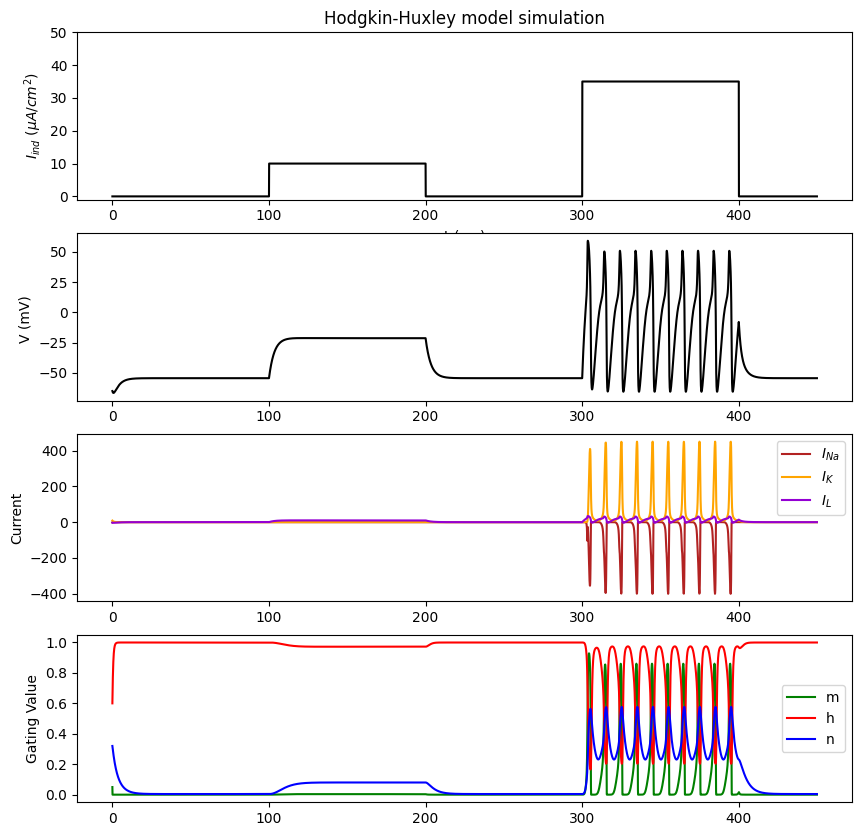

In [26]:
# Purpose: simulate action potentials in neurons by plotting the change in membrane potential
#          over time given an induced current. We calculate this change using the mathematical
#          relationships descrived in the Hodgkin-Huxley model.
#          See README.md for the intuition and sources used.

# Author: Tianning (T.T.) Chen
# Date: 2023-11-23

# import packages to help with data manipulation, solving differentials, and plotting the results ---------------------
import numpy as np
from scipy.integrate import odeint
import matplotlib.pyplot as plt

# given experimental values -------------------------------------------------------------------------------------------
Cm = 1                                      # uF/cm^2 --> capacitance of lipid bilayer (from SWT)
gNa_max, gK_max, gL = 120, 36, 0.3          # mS/cm^2 --> max conductance (g=1/R) of Na, K, & leak channels (from SWT)
E_Na, E_K, E_L = 60, -88, -54.387           # mV --> electrochemical gradients of Na, K, & other ions (from SWT)

# the slightest change in E makes the graphs look very different!!!

# gating variables {m, h, n} ------------------------------------------------------------------------------------------
# where m = probability that the Na channel is open (vs. closed)
# where h = probability that the Na channel is inactivated (vs. open)
# where n = probability that the K channel is open (vs. closed)

# voltage-dependent transition rates as calculated by Hodgkin-Huxley --------------------------------------------------
# for x = {m, h, n}
# where x_alpha = transition rate of channels from __ TO open (1/ms)
# and x_beta = transition rate of channels FROM open to __ (1/ms)
def m_alpha(Vm): return 0.1 * ((25-Vm) / (np.exp((25-Vm)/10) - 1))
def m_beta(Vm): return 4 * np.exp(-Vm/18)
def h_alpha(Vm): return 0.07 * np.exp(-Vm/20)
def h_beta(Vm): return 1 / (np.exp((30-Vm)/10) + 1)
def n_alpha(Vm): return 0.01 * ((10-Vm) / (np.exp((10-Vm)/10) - 1))
def n_beta(Vm): return 0.125 * np.exp(-Vm/80)

# current equations for Na, K, & leak channels (intuition from SWT) ---------------------------------------------------
def I_Na(Vm, m, h):
    gate_vars = np.multiply((m**3), (h))
    gNa = np.multiply(gNa_max, gate_vars)
    return np.multiply(gNa, (Vm-E_Na))
def I_K(Vm, n): return (gK_max) * (n**4) * (Vm-E_K)
def I_L(Vm): return (gL) * (Vm-E_L)

# set a time range of 450 milliseconds & injected current of 0, 10, 0, 35, 0 over time periods (from SWT) -------------
times = np.arange(0, 450, 0.1)
def I_ind(t):
    # return 10*(t>100) - 10*(t>200) + 35(t>300) - 35*(t>400)
    if t > 400:
        return 0
    if t > 300:
        return 35
    if t > 200:
        return 0
    if t > 100:
        return 10
    else:
        return 0


# calculate derivatives of membrane potential (simply "V" here) & gating variables w.r.t. time (from SWT) -------------
def dALLdt(X, t):
    V, m, h, n = X
    dVdt = (I_ind(t) - I_Na(V, m, h) - I_K(V, n) - I_L(V)) / Cm
    dmdt = m_alpha(V)*(1-m) - m_beta(V)*m
    dhdt = h_alpha(V)*(1-h) - h_beta(V)*h
    dndt = n_alpha(V)*(1-n) - n_beta(V)*n
    return dVdt, dmdt, dhdt, dndt


# solve differentials at each time step and store it in a matrix M (from SWT) ----------------------------------------
M = odeint(dALLdt, [-65, 0.05, 0.6, 0.32], times)
V = M[:, 0]
m = M[:, 1]
h = M[:, 2]
n = M[:, 3]

# plug in to solve for currents at all time steps (from SWT) ----------------------------------------------------------
ina = I_Na(V, m, h)
ik = I_K(V, n)
il = I_L(V)


# plot everything!!! (from SWT) ---------------------------------------------------------------------------------------
plt.figure(figsize=(10,10))


# make induced current values into an array
I_ind_vals = np.copy(times)
for i in range(np.shape(times)[0]):
    I_ind_vals[i] = I_ind(times[i])

# plot induced current
plt.subplot(4, 1, 1)
plt.title('Hodgkin-Huxley model simulation')
plt.plot(times, I_ind_vals, 'k')
plt.xlabel('t (ms)')
plt.ylabel('$I_{ind}$ ($\\mu{A}/cm^2$)')
plt.ylim(-1, 50)

# plot  voltage
plt.subplot(4, 1, 2)
plt.plot(times, V, 'k')
plt.ylabel('V (mV) ')

# plot current
plt.subplot(4, 1, 3)
plt.plot(times, ina, 'firebrick', label='$I_{Na}$')
plt.plot(times, ik, 'orange', label='$I_{K}$')
plt.plot(times, il, 'darkviolet', label='$I_{L}$')
plt.ylabel('Current')
plt.legend()

# plot gating values
plt.subplot(4, 1, 4)
plt.plot(times, m, 'g', label='m')
plt.plot(times, h, 'r', label='h')
plt.plot(times, n, 'b', label='n')
plt.ylabel('Gating Value')
plt.legend()


plt.show()